In [7]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import datetime


Cluster Analysis: To better understand what typical charging sessions look like, carry out a cluster
analysis to provide management with a succinct report of archetypical charging events. Think of an
appropriate trade-off between explainability and information content and try to come up with names
for these clusters. What is the value of identifying different types of charging sessions?

Different Clustering of the Data, Starting with kmeans

Month 

Time, KWh, Month, Temperature, doneCharging true/false, 
Maybe Charging time, onStationButNotChargingTime, siteId

Data Preparations for the Clustering

In [8]:
input_data = pd.read_csv("./charging_cleaned.csv")

# determining the total amount of seconds spent on the charging station
time_in = input_data["connectionTime"]
time_out = input_data["disconnectTime"]

time_in = pd.to_datetime(time_in)
time_out = pd.to_datetime(time_out)

#print(time_in)

time_all = time_out - time_in
#time_all.to_csv("./time_total.csv")

time_sec = np.zeros(time_all.size)

for i in range(time_all.size):
   time_sec[i] = int(time_all[i].total_seconds())


KWh = input_data["kWhDelivered"]



# time on charging station while not charging
time_wasted = input_data["doneChargingTime"]
time_wasted = pd.to_datetime(time_wasted)

time_wasted = time_out - time_wasted


# the donechargingtime is calculated and if the charging gets interrupted therefore time_donecharging > time_out 
time_wasted_sec = np.zeros(time_wasted.size)

for i in range(time_wasted.size):
   time_wasted_sec[i] = int(time_wasted[i].total_seconds())

# set all negativ due to the reason above to 0 -> no time on cable wasted
time_wasted_sec[time_wasted_sec < 0]  = 0

# time in percent that is not wasted
time_perc = (time_wasted_sec / time_sec) * 100

# registered user
reg_user = input_data["userID"]
reg_user[reg_user != 0] = 1 

#print(time_perc)

# preparing the months just using the connectiontime
month = time_in.dt.month 

#print(month)


# preparing the days just using the connectiontime
days = time_in.dt.day 

# preparing the siteId
site_Id = input_data["siteID"]

# preparing the datamatches from input and overall?
matches = input_data["date_matches"]

# time of the day
time_of_day = time_in.dt.hour 
print(time_of_day)

# time that would still need to not finished charging
time_left  =  input_data["doneChargingTime"]
time_left = pd.to_datetime(time_left)
time_left = time_left - time_out


time_left_sec = np.zeros(time_left.size)

for i in range(time_left.size):
   time_left_sec[i] = int(time_left[i].total_seconds())

# set all negativ due to the reason above to 0 -> no time on cable wasted
time_left_sec[time_left_sec < 0]  = 0


# All of the data from the user inputs, to see if there is a difference, userInputs_WhPerMile, userInputs_kWhRequested, userInputs_milesRequested, userInputs_minutesAvailable, userInputs_modifiedAt, userInputs_paymentRequired,  userInputs_requestedDeparture
# determining the total amount of seconds spent on the charging station
time_all_user = input_data["userInputs_minutesAvailable"]

KWh_user = input_data["userInputs_kWhRequested"]

# userInputs_WhPerMile
Wh_per_mile_user = input_data["userInputs_WhPerMile"]

# userInputs_milesRequested 
miles_req = input_data["userInputs_milesRequested"]

# userInputs_modifiedAt
mod_at = input_data["userInputs_modifiedAt"]

# userInputs_paymentRequired
pay_req = input_data["userInputs_paymentRequired"]

# userInputs_requestedDeparture
req_dep = input_data["userInputs_requestedDeparture"]




C:\Users\bkran\AppData\Local\Temp\ipykernel_40480\3613127506.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_user[reg_user != 0] = 1


0        13
1        13
2        13
3        13
4        14
         ..
66445    18
66446    18
66447    19
66448    19
66449    19
Name: connectionTime, Length: 66450, dtype: int32


K-Means Clustering

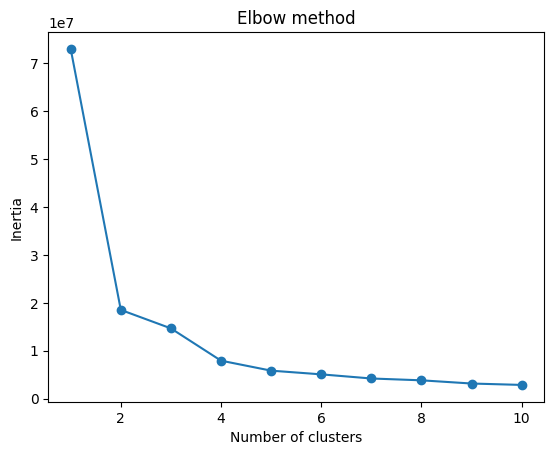

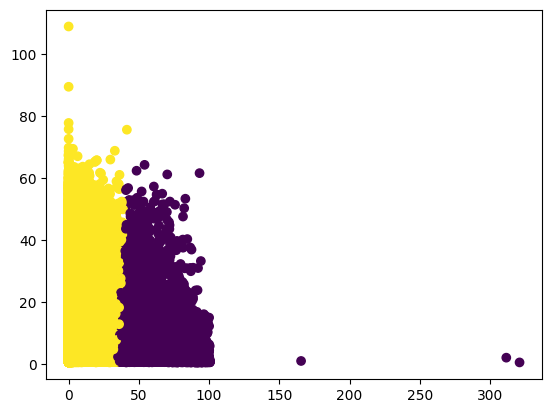

In [9]:
data = list(zip(time_perc, KWh))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

plt.scatter(time_perc, KWh, c=kmeans.labels_)
plt.show() 

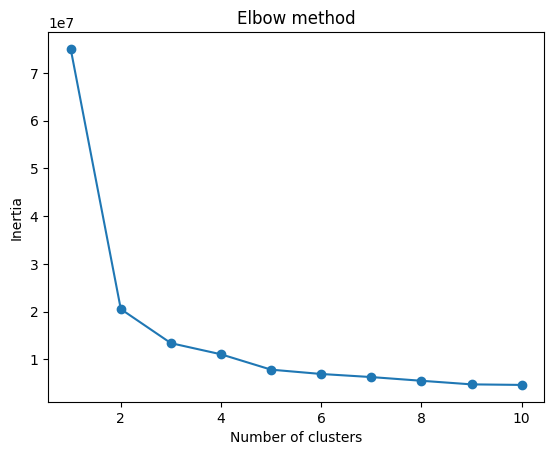

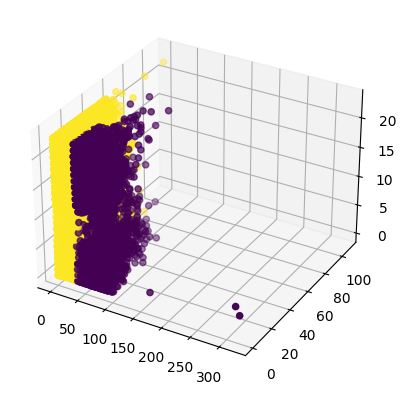

In [10]:
data = list(zip(KWh, time_perc, time_of_day))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

ax = plt.axes(projection='3d')

ax.scatter3D(time_perc, KWh, time_of_day,c=kmeans.labels_)


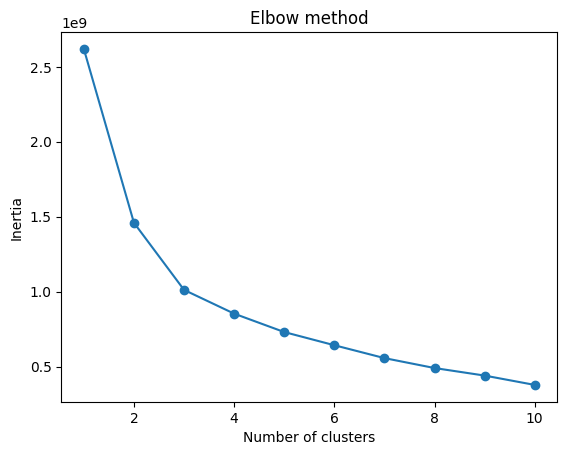

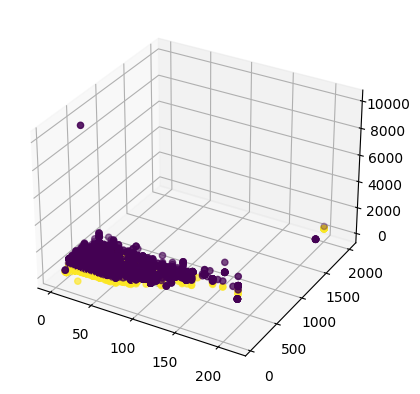

In [11]:
data = list(zip(KWh_user, Wh_per_mile_user, time_all_user))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

ax = plt.axes(projection='3d')

ax.scatter3D(KWh_user, Wh_per_mile_user, time_all_user,c=kmeans.labels_)

Clustering of the weather in combination with the data

In [ ]:
# data of weather
data_weather = pd.read_csv("./weather_cleaned.csv")
time_hd = data_weather["timestamp"]
time_hd = pd.to_datetime(time_hd).round('60min')
time_hd = (time_hd.dt.year - 2018) * 365 * 24 + time_hd.dt.day_of_year * 24 + time_hd.dt.hour
data_weather["time"] = time_hd

# data of 
data = pd.read_csv("./charging_cleaned.csv")
time_day_hour = data["connectionTime"]
time_day_hour = pd.to_datetime(time_day_hour).round('60min')
time_day_hour = (time_day_hour.dt.year - 2018) * 365 * 24 + time_day_hour.dt.day_of_year * 24 + time_day_hour.dt.hour
data["time"] = time_day_hour

print(time_day_hour)
# merging
merged_data = pd.merge(data_weather, data, on='time')
print(merged_data)


0        17581
1        17581
2        17581
3        17581
4        17582
         ...  
66445    13866
66446    13866
66447    13867
66448    13867
66449    13867
Name: connectionTime, Length: 66450, dtype: int32
                 timestamp  temperature  cloud_cover cloud_cover_description  \
0      2018-04-25 11:53:00         12.0         27.0           Mostly Cloudy   
1      2018-04-25 13:24:00         12.0         20.0                     Fog   
2      2018-04-25 13:24:00         12.0         20.0                     Fog   
3      2018-04-25 13:53:00         12.0         20.0                     Fog   
4      2018-04-25 13:53:00         12.0         20.0                     Fog   
...                    ...          ...          ...                     ...   
65866  2020-12-31 17:53:00         13.0         34.0                    Fair   
65867  2020-12-31 18:53:00         16.0         34.0                    Fair   
65868  2020-12-31 22:53:00         18.0         34.0             

In [30]:
# Getting the rest of the data ready 
temp = merged_data["temperature"]


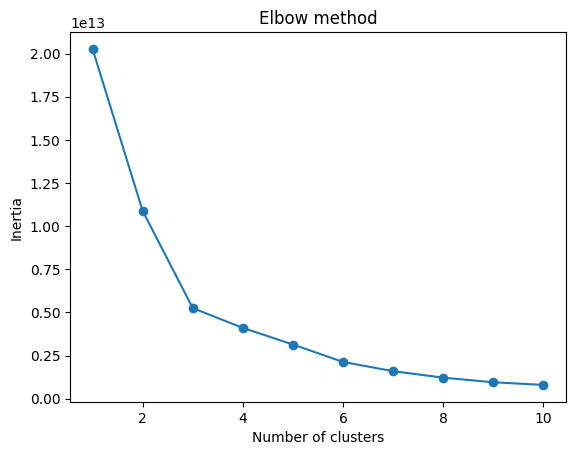

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (65871,) and arg 1 with shape (66450,).

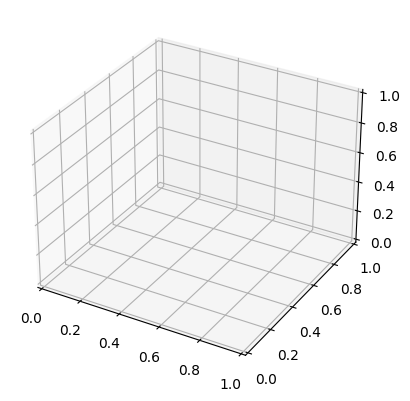

In [33]:
# Kmeans with weather
data = list(zip(temp, KWh, time_sec))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

ax = plt.axes(projection='3d')
ax.scatter3D(temp, KWh, time_sec, c=kmeans.labels_)